# Ames, Iowa Housing Price Predictions

### Overview
I completed this project as part of a Kaggle competition (see here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques). I visualized the various aspects of the dataset prior to cleaning null values and performing feature engineering. The main feature engineering work was to transform nominal features into numeric (boolean) features using pandas dummy variables, followed by empirical filtering of null values and correlation with the target value. The Extreme Gradient Boosting (XGBoost) decision-tree algorithm was used for modeling and prediction. 

The metric used for scoring by Kaggle is the root mean squared logarithmic error (RMSLE). This metric is similar to the more common root mean squared error, but does not penalize as heavily for extreme differences between actual and predicted values due to the logarithm. My final RMSLE was 0.12189. When comparing my final result to other Kaggle competitors, my model places within the top 30% (~520 out of 1800) as of October 4th, 2017. 

While this model could be further improved by additional feature engineering and more computational intensive machine learning algorithms, I was able to write this code from scratch in less than 5 hours. It's a relatively compact code that still achieves above average performance, with straight forward implemntation.

### Key Results
My RMSLE of 0.12189 would place ~520 out of 1800 entries (top 30%) as of October 4th, 2017.

### Methods used
- seaborn for feature visualization
- pandas dummy variables for transforming nominal features
- XGBoost modeling and predictions



# Reading in the Provided Dataset
The dataset contains roughly 3000 entries with various features that describe the house. The final sale price is included, and will be used as the target variable. The dataset was compiled by Dean De Cock: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf. 

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import pearsonr


data = pd.read_csv('AmesHousing.txt', '\t')
data = data.drop(['Order', 'PID'], axis=1)

print(data.shape)
data.head()

(2930, 80)


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Plotting the target variable—Sale Price
The sale price shows a slight skew towards higher prices, with a few potential outliers, but overall is relatively normally distributed.

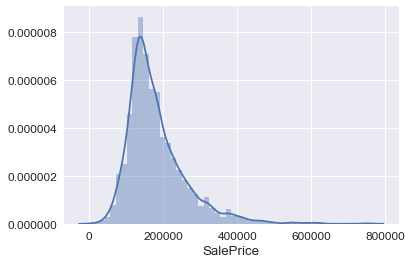

In [89]:
sns.distplot(data['SalePrice']);

# Visualizing Feature Correlations with Seaborn Heatmap
While there are some features with high multicollinearity, overall the features appear to be relatively independent. The XGBoost algorithm deals relatively well with multicollinearity, so while removing redundant features is good practice, it's likely not necessary in this case. Also note that this plot only shows the numerical features from the dataset. The dataset contains 80 features, but only 36 are numerical. The remaining 44 nominal features will be dealth with later on. 

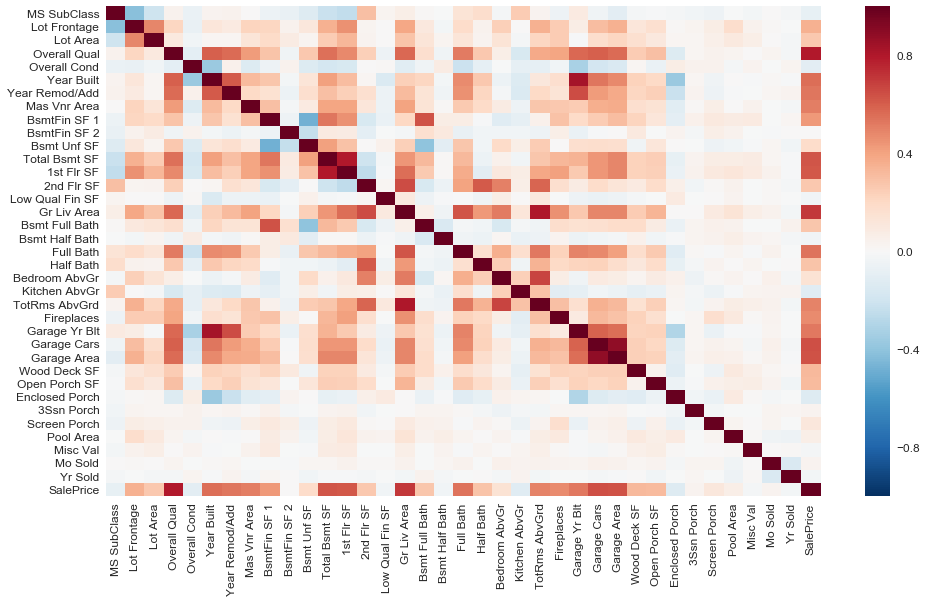

In [90]:
import seaborn as sns

plt.figure(figsize=(16,9))
corrmat = data.corr()
sns.heatmap(corrmat)

### Top 20 Features with Highest Correlation with Sale Price
Below the top 20 feature correlations with the target are shown. Overall quality, Living Area, Garage Area, and Basement size all seems to correlate strongly with the final sale price. These features make since because they're related to the size of the house, as well as the overall quality. The next few plots will show distributions with these features and the target Sale Price.

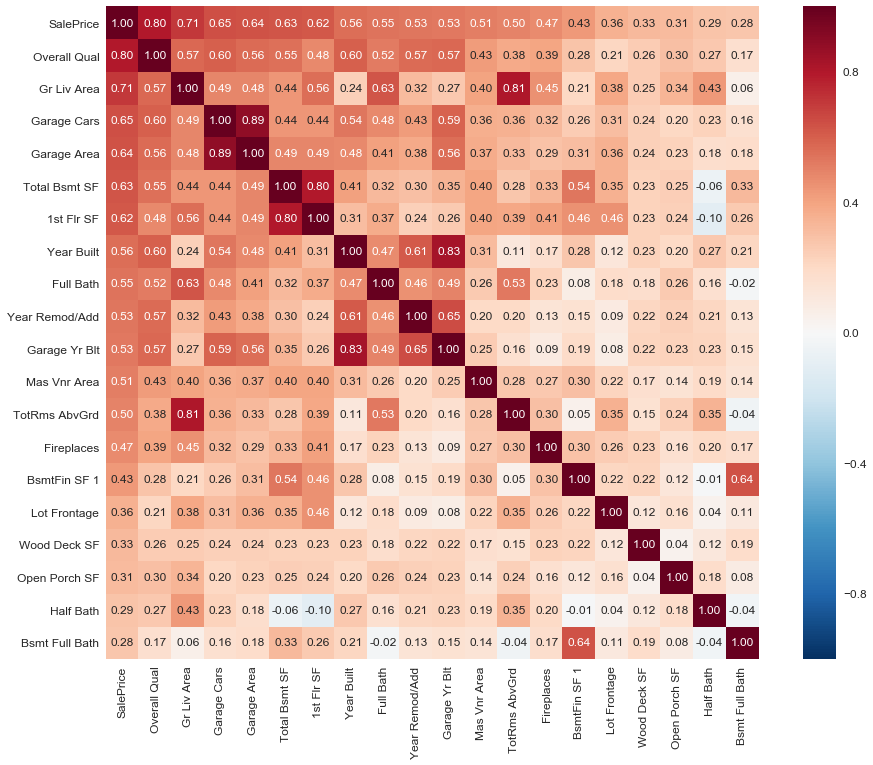

In [91]:
plt.figure(figsize=(16,12))
k = 20
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Visualizing Important Features
Overall quality has a definite correlation with Sale Price, increasing as Sale Price increases.

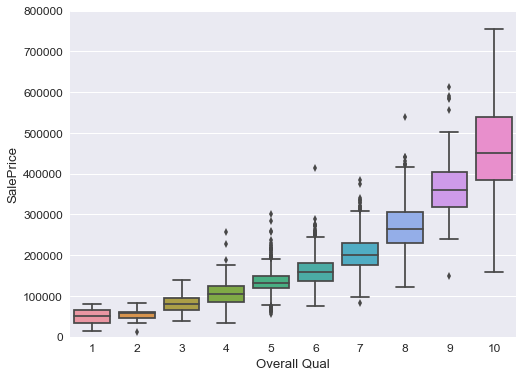

In [92]:
var = 'Overall Qual'
data_plot = pd.concat([data['SalePrice'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data_plot)
fig.axis(ymin=0, ymax=800000);

Living area also has a significant positive correlation with Sale Price. However, there are a few outliers, which the dataset author notes are due to short sales. I filtered the 5 houses with living area above 4000 to prevent them from skewing the final results.

(2925, 80)

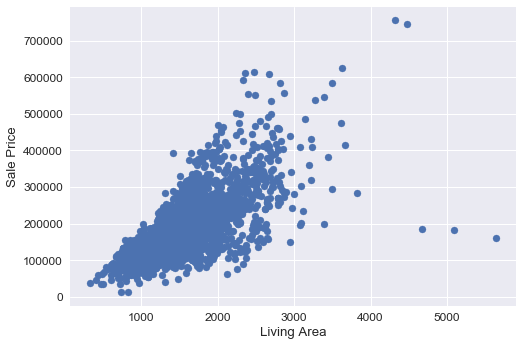

In [93]:
plt.scatter(data['Gr Liv Area'], data.SalePrice)
plt.xlabel('Living Area'), plt.ylabel('Sale Price')
data = data[data['Gr Liv Area'] < 4000].reset_index(drop=True)
data.shape

The basement square footage also positively correlates with sale price, with the most interesting aspect being the number of homes that do not have basements.

(<matplotlib.text.Text at 0x12049fef0>, <matplotlib.text.Text at 0x12088ce48>)

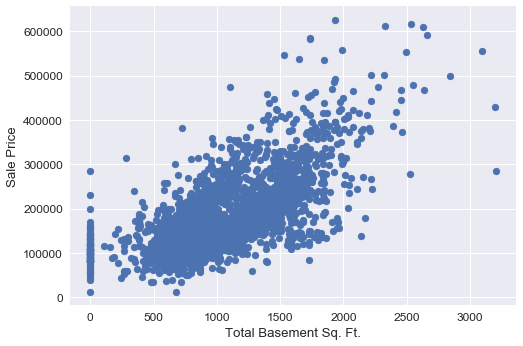

In [94]:
plt.scatter(data['Total Bsmt SF'], data.SalePrice)
plt.xlabel('Total Basement Sq. Ft.'), plt.ylabel('Sale Price')

The garage area looks very similar to the basement plot above.

(<matplotlib.text.Text at 0x120f76f98>, <matplotlib.text.Text at 0x120fcd6d8>)

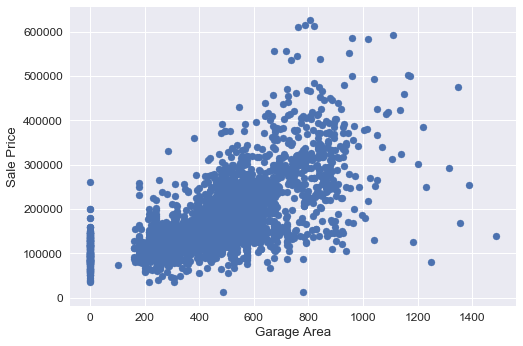

In [95]:
plt.scatter(data['Garage Area'], data.SalePrice)
plt.xlabel('Garage Area'), plt.ylabel('Sale Price')

# Missing values
Below the number of missing values are shown for nominal and numerical features. The strategy to deal with missing values will be to empirically set a cutoff for the max number of null features allowed. If a category has more null features than the cutoff, then it will simply be removed from the dataset. Any features remaining that contain null values will be replaced with the mean value for the column. The next two sections will describe in further detail.

In [96]:
data_objects = data.select_dtypes(include=['object'])
data_numerical = data.select_dtypes(include=['int', 'float'])
print('Null Nominal Categories:', "\n", data_objects.isnull().sum()[data_objects.isnull().sum() > 0], '\n')
print('Null Numerical Categories:', "\n", data_numerical.isnull().sum()[data_numerical.isnull().sum() > 0])

Null Nominal Categories: 
 Alley             2727
Mas Vnr Type        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin Type 2      81
Electrical           1
Fireplace Qu      1422
Garage Type        157
Garage Finish      159
Garage Qual        159
Garage Cond        159
Pool QC           2914
Fence             2354
Misc Feature      2820
dtype: int64 

Null Numerical Categories: 
 Lot Frontage      490
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     159
Garage Cars         1
Garage Area         1
dtype: int64


# Transforming Data and Selecting Features
The two functions below accomplish three main tasks:

1. Transforming nominal data into numerical (boolean) with the pandas get_dummies function.
2. Filtering features that contain null values based on a cutoff for the number of null values in the columns, and replacing any remaining null values with the column mean.
3. Selecting features based on their correlation with the target.

In [97]:
def transform_features(df, nominal, max_null):
    
    ## If the user selects to include nominal values, it will transform them using get_dummies
    ## Otherwise, it simply returns the numerical features
    if nominal == True:
        non_numeric = df.select_dtypes(include=['object'])
        dummy_df = pd.get_dummies(non_numeric)
        df = pd.concat([df, dummy_df], axis=1)
        df.drop(non_numeric.columns, axis=1, inplace=True)
    else:
        df = df.select_dtypes(include=['float', 'int'])
    
    ## All selected features are compared to a threshold value (max_null)
    ## that determines how many null values are allowed in the column.
    ## Any column with too many nulls is removed, with the rest replaced by the mean
    null_series = df.isnull().sum()
    null_features = null_series[null_series > 0]
    for col in null_features[null_features > max_null].index:
        del df[col]
    df = df.fillna(df.mean())
    
    ## Returns the feature dataframe X and the target series y
    X = df.drop('SalePrice', axis=1)
    y = df.SalePrice
    return X, y

In [98]:
def select_features(df, nominal, max_null, corr_value):
    
    ## Receives cleaned dataframes from the previous function
    X, y = transform_features(df, nominal, max_null)
    
    ## filters columns based on their correlation with the target
    for col in X.columns:
        corr = pearsonr(X[col], y)
        if abs(corr[0]) < corr_value:
            del X[col]
    
    return X, y

# Machine Learning Modeling and Predictions
Below, I use XGBoost to calculate the root mean squared logarithmic error (RMSLE) of various models. The two parameters that I will focus on are the number of null features allowed in the model, as well as the correlation of the feature with the target.

In [99]:
## function for calculating the RMSLE for a predicted and actual dataset

def rmsle(predicted, actual):
    assert(len(predicted) == len(actual))
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    return (((p - a)**2).sum() / len(predicted))**0.5

### Model Function
This model takes in the dataframe, passes it through the transform_features and select_features algorithms, and splits the data into train and test sets. The train/test splits are the same as used in the Kaggle competition (50/50) and do not include a cross-validation set. The training is done using XGBoost, followed by analysis by RMSLE.

In [100]:
from xgboost import XGBRegressor

def train_and_test(df, nominal, max_null, corr_cutoff, estimators, learn_rate, n_stops):
    
    rmsles = {}
    for val in corr_cutoff:
        X, y = select_features(df, nominal, max_null, val)
        X_train = X[:1460]
        y_train = y[:1460]
        X_test = X[1460:]
        y_test = y[1460:]

        my_model = XGBRegressor(n_estimators=estimators, learning_rate=learn_rate)
        my_model.fit(X_train, y_train, early_stopping_rounds=n_stops, eval_set=[(X_test, y_test)], verbose=False)
        predictions = my_model.predict(X_test)

        prediction = my_model.predict(X_test)
        rmsle_val = rmsle(prediction, y_test)
        rmsles[val] = rmsle_val
    return rmsles

### Inclusion of Nominal Variables
The first test is whether the inclusion of nominal variables improves model accuracy. As shown below, the RMSLE does indeed drop when using nominal variables.

In [101]:
no_nominal = train_and_test(data, False, 160, [.05], 1000, .05, 5)
yes_nominal = train_and_test(data, True, 160, [.05], 1000, .05, 5)

print('No Nominal Features, RMSLE: ', no_nominal[0.05])
print('Yes Nominal Features, RMSLE: ', yes_nominal[0.05])

No Nominal Features, RMSLE:  0.131513727881
Yes Nominal Features, RMSLE:  0.12482046215


Next, various cutoffs for feature correlation with the target, and cutoffs for the maximum number of null values will be empirically explored. The output will be a dictionary key for each null value cutoff, with an inner dictionary containing each individual correlation cutoff. The plot below will visualize these results.

In [102]:
corr_cutoffs = [0, 0.03, 0.05, 0.07, 0.1, .15]
null_cutoffs = [0, 1, 25, 160, 500]

results = {}
for null_val in null_cutoffs:
    rmsle_result = train_and_test(data, True, null_val, corr_cutoffs, 1000, .05, 5)
    results[null_val] = round(rmsle_result, 5)
    
results

{0: {0: 0.13207352303612682,
  0.03: 0.1295802924890308,
  0.05: 0.12993685429780624,
  0.07: 0.13094804423886355,
  0.1: 0.13151431275907544,
  0.15: 0.13830597151483828},
 1: {0: 0.12639054877758757,
  0.03: 0.12627687069039353,
  0.05: 0.12817599466211485,
  0.07: 0.12684713360351957,
  0.1: 0.12600552392937489,
  0.15: 0.13484893817245452},
 2: {0: 0.1265914461579041,
  0.03: 0.12734593318019319,
  0.05: 0.12529191367030995,
  0.07: 0.12630409188545791,
  0.1: 0.12744510414983873,
  0.15: 0.13614967076180695},
 25: {0: 0.12705068001493067,
  0.03: 0.12649520525608143,
  0.05: 0.12545843809950688,
  0.07: 0.1262753244600828,
  0.1: 0.12563108884519114,
  0.15: 0.13500504088150264},
 160: {0: 0.12513986156994164,
  0.03: 0.12599755178241068,
  0.05: 0.12482046215038238,
  0.07: 0.1250906325413958,
  0.1: 0.1261190012520701,
  0.15: 0.13529079546052025},
 500: {0: 0.12626449319508434,
  0.03: 0.12574394435276232,
  0.05: 0.12744106609980185,
  0.07: 0.12579025150213718,
  0.1: 0.12700

As shown in the graph below, the correlation cutoff does not significantly effect the output, except for above 0.1. In terms of the null cutoff, it appears that not including any columns with null values (null cutoff = 0) performs the worst. The best null cutoff mean belongs to null cutoff = 160 values.

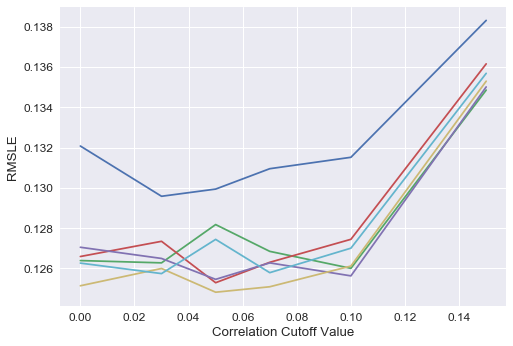

null cutoff = 0 : 0.132059833056
null cutoff = 1 : 0.128090834973
null cutoff = 2 : 0.128188026634
null cutoff = 25 : 0.127652629593
null cutoff = 160 : 0.127076384126
null cutoff = 500 : 0.127987404737


In [103]:
null_results = []
for k, v in results.items():
    x = list(v.keys())
    y = list(v.values())
    null_results.append(y)
    plt.plot(x, y)
    plt.ylabel('RMSLE')
    plt.xlabel('Correlation Cutoff Value')
plt.show()

for null_val in null_cutoffs:
    print('null cutoff =', null_val,':', np.mean(list(results[null_val].values())))

While there was not much variation in correlation cutoff, in generall values between 0.04 and 0.06 performed best. The code below uses a null cutoff of 160 and more aggressive learning rates to create a final prediction. The correlation cutoff will be varied between 0.04 and 0.06 to find an optimal solution.

In [107]:
rmsle_result = train_and_test(data, True, 160, [.04, .05, .06], 2500, .02, 30)
rmsle_result

{0.03: 0.12381018203172368,
 0.04: 0.1220062161232094,
 0.05: 0.1223466848069763,
 0.06: 0.12189365998405864,
 0.07: 0.12420778423849546}

This final result gives an RMSLE of 0.12189. This value would place ~525th out of ~1800 entries in the Kaggle competition, with relatively minimal coding and optimization. While the null values and correlation cutoffs were optimized on the test set, I note that this should typically be done on a cross-validation set prior to running on the test set. However, this was not done due to the setup of the Kaggle competition.

In [105]:
final_result = rmsle_result[0.06]
print('Final RMSLE: ', final_result)

Final RMSLE:  0.121893659984
